In [125]:
import os
import pandas as pd
import torch
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class CustomImageDataset(Dataset):
    def __init__(self, annotation_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotation_file, header=None)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        slicer = slice(-9)
        img_path1 = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0][slicer], self.img_labels.iloc[idx, 0])
        img_path2 = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1][slicer], self.img_labels.iloc[idx, 1])
        image1 = read_image(img_path1)
        image2 = read_image(img_path2)
        label = self.img_labels.iloc[idx, 2]
        
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        if self.target_transform:
            label = self.target_transform(image1)
        return image1, image2, label, img_path1, img_path2

datasetPath = f"/Users/necatiisik/lfw_dataset/lfw/"
trainLabelPath = f"/Users/necatiisik/lfw_dataset/pair_train_data.csv"
testLabelPath = f"/Users/necatiisik/github_lib/vsEnv/res/2k_test.csv"


preprocess = transforms.Compose([
  transforms.ToPILImage(),
  transforms.Resize(size=140),  # Conver 140x140 input images
  transforms.ToTensor()
#   transforms.Normalize(
#       mean=[0.6071, 0.4609, 0.3944],  # Normalization settings for the model, the calculated mean and std values
#       std=[0.2457, 0.2175, 0.2129]     # for the RGB channels of the tightly-cropped glint360k face dataset
#   )
])

train_data = CustomImageDataset(trainLabelPath, datasetPath, transform=preprocess, target_transform=None)
test_data = CustomImageDataset(testLabelPath, datasetPath, transform=preprocess, target_transform=None)

batch_size = 64

train_loader = DataLoader(dataset = train_data,
                          batch_size = batch_size, 
                          shuffle = True)

test_loader = DataLoader(dataset = test_data,
                         batch_size = batch_size, 
                         shuffle = True)

In [56]:
from __future__ import print_function
import argparse, random, copy
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms as T
from torch.optim.lr_scheduler import StepLR


class SiameseNetwork(nn.Module):
    """
        Siamese network for image similarity estimation.
        The network is composed of two identical networks, one for each input.
        The output of each network is concatenated and passed to a linear layer. 
        The output of the linear layer passed through a sigmoid function.
        `"FaceNet" <https://arxiv.org/pdf/1503.03832.pdf>`_ is a variant of the Siamese network.
        This implementation varies from FaceNet as we use the `ResNet-18` model from
        `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_ as our feature extractor.
        In addition, we aren't using `TripletLoss` as the MNIST dataset is simple, so `BCELoss` can do the trick.
    """
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # get resnet model
        self.resnet = torchvision.models.resnet18(weights=None)

        # over-write the first conv layer to be able to read MNIST images
        # as resnet18 reads (3,x,x) where 3 is RGB channels
        # whereas MNIST has (1,x,x) where 1 is a gray-scale channel
        # overruled.. get (3,x,x)
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.fc_in_features = self.resnet.fc.in_features
        
        # remove the last layer of resnet18 (linear layer which is before avgpool layer)
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))

        # add linear layers to compare between the features of the two images
        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features * 2, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )

        self.sigmoid = nn.Sigmoid()

        # initialize the weights
        self.resnet.apply(self.init_weights)
        self.fc.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward_once(self, x):
        output = self.resnet(x)
        output = output.view(output.size()[0], -1)
        return output

    def forward(self, input1, input2):
        # get two images' features
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        # concatenate both images' features
        output = torch.cat((output1, output2), 1)

        # pass the concatenation to the linear layers
        output = self.fc(output)

        # pass the out of the linear layers to sigmoid layer
        output = self.sigmoid(output)
        
        return output

In [41]:
model = SiameseNetwork().to(device)

def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_param = count_parameters(model)

print(f"{num_param:,}")

11,439,169


/var/folders/yg/vjnq2s395_5652ng6cshx95h0000gn/T/ipykernel_1129/3421993037.py:57: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


In [57]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()

    # we aren't using `TripletLoss` as the MNIST dataset is simple, so `BCELoss` can do the trick.
    criterion = nn.BCELoss()

    for batch_idx, (images_1, images_2, targets, path1, path2) in enumerate(train_loader):
        images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device, torch.float32)
        optimizer.zero_grad()
        outputs = model(images_1, images_2).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if batch_idx % 2 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(images_1), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    return loss.item()
            # if args.dry_run:
            #     break

In [58]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    # we aren't using `TripletLoss` as the MNIST dataset is simple, so `BCELoss` can do the trick.
    criterion = nn.BCELoss()

    with torch.no_grad():
        for (images_1, images_2, targets, path1, path2) in test_loader:
            images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device, torch.float32)
            outputs = model(images_1, images_2).squeeze()
            test_loss += criterion(outputs, targets).sum().item()  # sum up batch loss
            pred = torch.where(outputs > 0.5, 1, 0)  # get the index of the max log-probability
            correct += pred.eq(targets.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    # for the 1st epoch, the average loss is 0.0001 and the accuracy 97-98%
    # using default settings. After completing the 10th epoch, the average
    # loss is 0.0000 and the accuracy 99.5-100% using default settings.
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return test_loss

In [ ]:
import matplotlib.pyplot as plt

model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("siamese_network_resnet_A-S-A-S.pt", map_location = device))
optimizer = optim.Adadelta(model.parameters(), lr=1.0)

lossTrain = []
lossTest = []
epochs = []

tot_epoch  = 10
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
for epoch in range(tot_epoch):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    test_loss = test(model, device, test_loader)
    scheduler.step()
    lossTrain.append(train_loss)
    lossTest.append(test_loss)
    epochs.append(epoch)

    plt.plot(epochs, lossTrain, 'g', label='Training loss')
    plt.plot(epochs, lossTest, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



    

torch.save(model.state_dict(), "siamese_network.pt")

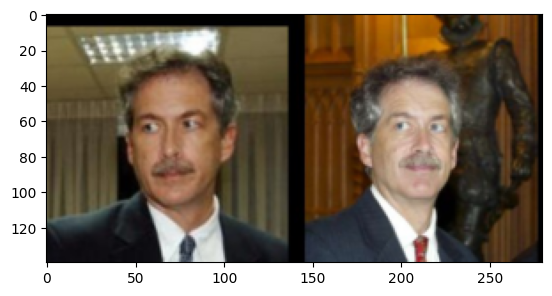

1st image: William_Burns_0001.jpg -- 2nd image: William_Burns_0002.jpg
Label of the data: 1 (1: Same, 0: Not)
1000
Output: 0.7982578873634338, Prediction: 1


In [117]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def random_evaluate(model, device, datasetLoader):
    model.eval()
    # we aren't using `TripletLoss` as the MNIST dataset is simple, so `BCELoss` can do the trick.
    criterion = nn.BCELoss()

    with torch.no_grad():
        images_1, images_2, targets, path1, path2 = next(iter(datasetLoader))
        img1, img2, target = images_1[0], images_2[0], targets[0]
        output = model(images_1, images_2).squeeze()
        pred = torch.where(output > 0.5, 1, 0)  # get the index of the max log-probability

        img1 = img1.squeeze()
        img1 = img1.movedim(0, -1)
        img2 = img2.squeeze()
        img2 = img2.movedim(0, -1)
        img1 = torch.cat((img1, img2), 1)

        label = target
        plt.imshow(img1)
        plt.show()
        first_image_label = path1[0].split("/")[6]
        second_image_label = path2[0].split("/")[6]

    print(f"1st image: {first_image_label} -- 2nd image: {second_image_label}")
    print(f"Label of the data: {label} (1: Same, 0: Not)")
    print(len(datasetLoader.dataset))

    return output, pred 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("siamese_network_resnet_A-S-A-S.pt", map_location = device))

output, pred = random_evaluate(model, device, test_loader)

print(f"Output: {output[0]}, Prediction: {pred[0]}")



In [130]:
# ROC curve
import numpy as np
import matplotlib.pyplot as plt

def ROCcurve(model, device, test_loader, threshold):
    model.eval()
    correct = 0
    predicted_true = 0

    criterion = nn.BCELoss()

    with torch.no_grad():
        for (images_1, images_2, targets, path1, path2) in test_loader:
            images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device, torch.float32)
            outputs = model(images_1, images_2).squeeze()
            pred = torch.where(outputs > threshold, 1, 0)  # get the index of the max log-probability
            predicted_true += pred.sum().item()
            correct += pred.eq(targets.view_as(pred)).sum().item()


    return correct, predicted_true


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("siamese_network_resnet_A-S-A-S.pt", map_location = device))

prediction_list = []


for threshold in np.linspace(0,1,5):
    correct, pred = ROCcurve(model, device, test_loader, threshold)
    false_positive = correct-pred+correct-2000
    prediction_list.append((correct, false_positive))

print(prediction_list)
# print(f"Correct Count: {correct}, Prediction: {pred}, False Positive: {correct-pred+correct-2000}")
